In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
train_df = pd.read_csv("data/train.csv", low_memory=True).iloc[:,1:]  # drop index column

In [ ]:
train_df.head()

# Exploratory Data Analysis

In [ ]:
# let's inspect geographical data
# First, look at temperature in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="fact_temperature",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

In [ ]:
# Now, look at climate pressure in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="climate_pressure",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

In [ ]:
# Look at climate temperature in different areas
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="climate_temperature",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

We can see how training data is coming from all around the world, with some exceptions: center and north South America and center of Africa.

## Target Variable

In [ ]:
import seaborn as sns

def plot_violin_plot(column):
  sns.set_theme(style="whitegrid")
  ax = sns.violinplot(y=column)

plt.figure(figsize=(8,6))
plot_violin_plot(train_df["fact_temperature"])
plt.show()

In [ ]:
percentile_99_99 = train_df["fact_temperature"].quantile(0.9999)
percentile_0_01 = train_df["fact_temperature"].quantile(0.0001)
percentile_99_9 = train_df["fact_temperature"].quantile(0.999)
percentile_0_1 = train_df["fact_temperature"].quantile(0.001)
percentile_99 = train_df["fact_temperature"].quantile(0.99)
percentile_1 = train_df["fact_temperature"].quantile(0.1)


print(f"Percentile 99.99 %: {percentile_99_99}")
print(f"Percentile 0.01 %: {percentile_0_01}")
print(f"Percentile 99.9 %: {percentile_99_9}")
print(f"Percentile 0.1 %: {percentile_0_1}")
print(f"Percentile 99 %: {percentile_99}")
print(f"Percentile 1 %: {percentile_1}")

print(f"Percentile 99.99 % data over: { ( train_df['fact_temperature'] >= percentile_99_99).sum()} ")
print(f"Percentile 0.01 % data under: { ( train_df['fact_temperature'] <= percentile_0_01).sum()} ")
print(f"Percentile 99.9 % data over: { ( train_df['fact_temperature'] >= percentile_99_9).sum()} ")
print(f"Percentile 0.1 % data under: { ( train_df['fact_temperature'] <= percentile_0_1).sum()} ")
print(f"Percentile 99 % data over: { ( train_df['fact_temperature'] >= percentile_99).sum()} ")
print(f"Percentile 1 % data under: { ( train_df['fact_temperature'] <= percentile_1).sum()}")

# Data cleaning

In [ ]:
# check that all features are numerical -> yes, so we don't need encoding
train_df.info()

In [ ]:
print(f"NaN values before dealing with them: {train_df.isna().sum().sum()}")

In [ ]:
# All NaN values are in the following records
print(f"gfs records not available: {(train_df['gfs_available'] == 0).sum()}")
print(f"cmc records not available: {(train_df['cmc_available'] == 0).sum()}")
print(f"wrf records not available: {(train_df['wrf_available'] == 0).sum()}")

In [4]:
# 0 if not NaN, 1 if cmc is missing, 2 if wrf is missing
nan_points_cmc = (train_df['cmc_available'] == 0).replace({True: 1, False: 0})
nan_points_wrf = (train_df['wrf_available'] == 0).replace({True: 2, False: 0})
nan_points_flag = pd.concat([nan_points_cmc, nan_points_wrf]).groupby(level=0).sum()
train_df["flag"] = nan_points_flag
train_df.head()

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,...,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature,flag
0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,...,0.0,0.0,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0,0
1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,...,0.0,0.0,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0,0
2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,0.625,...,0.0,0.0,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0,2
3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,...,0.0,0.0,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0,0
4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,...,0.0,0.0,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0,0


In [ ]:
# NOT NaN data - we see that half of Australia points are records with NaN values
train_df[train_df["flag"] == 0].plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4,
              cmap=plt.get_cmap("jet"), figsize=(15,7))
plt.show()

In [ ]:
# We can see how half of Australia consists of records with NaN values
train_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4, c="flag",
              cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,7))
plt.show()

In [5]:
# drop available data feature and its flag which was useful for visualization only
train_df = train_df.drop(columns=["gfs_available", "cmc_available", "wrf_available", "flag"])

In [6]:
# We can NOT remove records with NaN values since we would lose information about half of Oceania
# We will sort by latitude and longitude, then use a bfill and ffill approaches, then restore original order by index
train_df = train_df.sort_values(["fact_latitude", "fact_longitude"])
train_df = train_df.fillna(method="bfill")
train_df = train_df.fillna(method="ffill")
train_df = train_df.sort_index()
train_df

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,...,0.0,0.0,0.000000,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,...,0.0,0.0,0.000000,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,0.625,...,0.0,0.0,0.000000,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0
3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,...,0.0,0.0,0.000000,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,...,0.0,0.0,0.000000,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993569,1.543543e+09,32.297199,50.842201,2042.0,-19.050859,2.247143,583.410553,262.803375,21.750,3.625,...,0.0,0.0,0.000002,0.0,0.0,-0.899994,-8.449988,0.0,0.0,-2.0
1993570,1.541552e+09,36.191898,-94.489998,361.0,-6.690413,13.887143,732.386076,281.155746,5.500,3.875,...,0.0,0.0,0.000000,0.0,0.0,-1.136932,6.113062,16.0,99.0,12.0
1993571,1.545372e+09,38.808899,27.833900,76.0,4.815581,4.407143,750.746603,267.692017,6.625,0.625,...,0.0,0.0,0.000000,0.0,0.0,1.314484,0.850000,0.0,0.0,-2.0
1993572,1.544355e+09,18.310000,-15.969722,-7.0,38.690343,19.170714,760.737441,278.651733,19.500,13.250,...,0.0,0.0,0.000000,0.0,0.0,1.000000,10.850000,0.0,0.0,28.0


In [7]:
train_df.isna().sum().sum()

0

In [8]:
# remove duplicates
train_df.drop_duplicates(inplace=True, ignore_index=True)
train_df

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,...,0.0,0.0,0.000000,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,...,0.0,0.0,0.000000,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,0.625,...,0.0,0.0,0.000000,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0
3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,...,0.0,0.0,0.000000,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,...,0.0,0.0,0.000000,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987837,1.543543e+09,32.297199,50.842201,2042.0,-19.050859,2.247143,583.410553,262.803375,21.750,3.625,...,0.0,0.0,0.000002,0.0,0.0,-0.899994,-8.449988,0.0,0.0,-2.0
1987838,1.541552e+09,36.191898,-94.489998,361.0,-6.690413,13.887143,732.386076,281.155746,5.500,3.875,...,0.0,0.0,0.000000,0.0,0.0,-1.136932,6.113062,16.0,99.0,12.0
1987839,1.545372e+09,38.808899,27.833900,76.0,4.815581,4.407143,750.746603,267.692017,6.625,0.625,...,0.0,0.0,0.000000,0.0,0.0,1.314484,0.850000,0.0,0.0,-2.0
1987840,1.544355e+09,18.310000,-15.969722,-7.0,38.690343,19.170714,760.737441,278.651733,19.500,13.250,...,0.0,0.0,0.000000,0.0,0.0,1.000000,10.850000,0.0,0.0,28.0


# Outliers removal

In [ ]:
# IQR METHOD

percentile25 = train_df['fact_temperature'].quantile(0.25)
percentile75 = train_df['fact_temperature'].quantile(0.75)
iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(f"Temperature upper limit: {upper_limit}")
print(f"Temperature lower limit: {lower_limit}")

print(f"Number of data that exceeds temperature upper limit: {train_df[train_df['fact_temperature'] > upper_limit].shape[0]}")
print(f"Number of data that exceeds temperature lower limit: {train_df[train_df['fact_temperature'] < lower_limit].shape[0]}")

print(f"Len of train_df: {train_df.shape[0]} ")

train_df =  train_df.drop( train_df[train_df['fact_temperature'] > upper_limit].index) # drop record over the upper limit
train_df =  train_df.drop( train_df[train_df['fact_temperature'] < lower_limit].index) # drop record under the upper limit

print(f"Len of train_df: {train_df.shape[0]}")


# Features Engineering

In [ ]:
from datetime import datetime

def get_hour(date, n_intervals = 6):
    hour = date.hour
    hours_in_interval = 24 // n_intervals
    return hour // hours_in_interval


def get_month_and_hour(df, test=False):
    datetimes = df["fact_time"].apply(datetime.utcfromtimestamp)
    if not test:
        # save y and add it at the end
        y = df["fact_temperature"]
        df.drop(columns=["fact_time", "fact_temperature"], inplace=True)
        df["month"] = datetimes.apply(lambda date: date.month)
        df["hour"] = datetimes.apply(get_hour) # get hour in intervals
        df["fact_temperature"] = y
    else:
        df.drop(columns=["fact_time"], inplace=True)
        df["month"] = datetimes.apply(lambda date: date.month)
        df["hour"] = datetimes.apply(get_hour) # get hour in intervals
    return df

In [9]:
from datetime import datetime

def get_hour(date, n_intervals = 6):
    hour = date.hour

    hours_in_interval = 24 // n_intervals

    return hour // hours_in_interval


def get_categorical_month_and_hour(df):

    datetimes = df["fact_time"].apply(datetime.utcfromtimestamp)

    df["month"] = datetimes.apply(lambda date: date.month)
    df["hour"] = datetimes.apply(get_hour) # get hour in intervals

    return pd.get_dummies(data=df, columns=['month', 'hour'])

In [10]:
train_df = get_categorical_month_and_hour(train_df)

train_df = train_df.drop(columns=["fact_time"])
train_df.head()

,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,cmc_0_0_7_500,...,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5
0,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,7.625,3.814694,...,0,1,0,0,0,0,0,1,0,0
1,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,8.375,15.508391,...,0,1,0,0,0,0,0,1,0,0
2,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,0.625,25.085211,...,0,0,1,0,0,0,1,0,0,0
3,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,0.375,7.367288,...,0,0,0,1,1,0,0,0,0,0
4,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,4.625,19.181682,...,0,1,0,0,0,1,0,0,0,0


# Feature selection

In [11]:
def get_correlated_features(df, threshold, method='pearson'):
    corr_matrix = df.corr(method=method).abs()
    high_corr_var=np.where(corr_matrix>threshold)
    high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
    # features and how many times they appear in tuples of correlated features
    features_count = pd.Series(sum(np.array(high_corr_var).tolist(), [])).value_counts()
    to_del = set()
    for pair in high_corr_var:
        if features_count[pair[0]] > features_count[pair[1]]:
            to_del.add(pair[0])
        else:
            to_del.add(pair[1])
    return list(to_del)

In [12]:
# drop correlated gfs, cmc and wrf features
df_cmc_gfs_wrf = train_df[train_df.columns.values[train_df.columns.str.contains("gfs") | 
                                                  train_df.columns.str.contains("cmc") |
                                                  train_df.columns.str.contains("wrf")]]

# pearson: linear relation between two variables
features_to_remove_pearson = get_correlated_features(df_cmc_gfs_wrf, threshold=0.8, method='pearson')

# spearman: monotonic relation between a pair of variables
# features_to_remove_spearman = get_correlated_features(df_cmc_gfs_wrf, threshold=0.8, method='spearman')


# See differences between the two methods
# features_to_remove_pearson = set(features_to_remove_pearson)
# features_to_remove_spearman = set(features_to_remove_spearman)

features_to_remove = features_to_remove_pearson
features_to_remove

['gfs_temperature_40000',
 'gfs_temperature_80000',
 'gfs_temperature_90000',
 'gfs_temperature_10000',
 'cmc_0_1_65_0_grad',
 'cmc_0_3_5_1000',
 'cmc_0_2_3_700',
 'gfs_timedelta_s',
 'cmc_0_2_3_925',
 'cmc_0_2_2_1000',
 'wrf_t2_interpolated',
 'gfs_temperature_75000',
 'cmc_0_2_2_10',
 'gfs_pressure',
 'cmc_0_2_2_700',
 'gfs_horizon_h',
 'wrf_rh2',
 'cmc_0_2_3_10',
 'gfs_total_clouds_cover_low_next',
 'cmc_0_3_0_0_next',
 'cmc_0_3_5_925',
 'gfs_2m_dewpoint',
 'gfs_temperature_50000',
 'cmc_0_1_67_0_next',
 'gfs_temperature_60000',
 'gfs_temperature_95000',
 'gfs_temperature_70000',
 'gfs_temperature_65000',
 'gfs_temperature_30000',
 'cmc_0_2_2_925',
 'wrf_psfc',
 'gfs_temperature_35000',
 'cmc_0_3_5_500',
 'gfs_total_clouds_cover_middle',
 'gfs_temperature_92500',
 'gfs_temperature_7000',
 'gfs_temperature_97500',
 'gfs_precipitable_water',
 'gfs_temperature_55000',
 'gfs_2m_dewpoint_next',
 'gfs_soil_temperature_available',
 'cmc_0_0_7_2',
 'cmc_0_1_68_0_next',
 'cmc_0_1_0_0',
 'cmc

In [13]:
# check correlation between target variable and other features
corr_target = train_df.corrwith(train_df["fact_temperature"]).sort_values(ascending=False)
corr_target

fact_temperature         1.000000
wrf_t2_interpolated      0.939950
wrf_t2_next              0.935109
gfs_temperature_97500    0.874742
gfs_temperature_95000    0.863473
                           ...   
cmc_0_3_1_0             -0.359353
fact_latitude           -0.408778
gfs_temperature_7000    -0.414672
gfs_temperature_15000   -0.502556
gfs_temperature_10000   -0.593965
Length: 120, dtype: float64

In [14]:
final_train_df = train_df.drop(columns=features_to_remove)
final_train_df

,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_500,cmc_0_0_7_700,...,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5
0,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,3.814694,0.875,...,0,1,0,0,0,0,0,1,0,0
1,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,15.508391,10.000,...,0,1,0,0,0,0,0,1,0,0
2,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,25.085211,2.250,...,0,0,1,0,0,0,1,0,0,0
3,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,7.367288,16.750,...,0,0,0,1,1,0,0,0,0,0
4,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,19.181682,7.875,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987837,32.297199,50.842201,2042.0,-19.050859,2.247143,583.410553,262.803375,21.750,29.914574,17.875,...,0,0,1,0,1,0,0,0,0,0
1987838,36.191898,-94.489998,361.0,-6.690413,13.887143,732.386076,281.155746,5.500,16.058111,11.250,...,0,0,1,0,1,0,0,0,0,0
1987839,38.808899,27.833900,76.0,4.815581,4.407143,750.746603,267.692017,6.625,18.831706,24.750,...,0,0,0,1,0,1,0,0,0,0
1987840,18.310000,-15.969722,-7.0,38.690343,19.170714,760.737441,278.651733,19.500,29.925248,30.000,...,0,0,0,1,0,0,1,0,0,0


# Scaling of features

In [15]:
from sklearn.preprocessing import StandardScaler

# Get X_train and y_train and normalize
X_train = final_train_df.drop(columns=['fact_temperature'])
y_train = final_train_df['fact_temperature']

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

scy = StandardScaler()
scy.fit(y_train.to_numpy().reshape(-1, 1))
y_train = scy.transform(y_train.to_numpy().reshape(-1, 1))

# PCA feature selection

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_sf = X_train.copy()


percentage_of_variance = 0.95
pca = PCA(percentage_of_variance)
X_train_pca = pca.fit_transform(X_sf)

In [ ]:
# plot is wrong, the rest should be good
 
exp_var_pca = pca.explained_variance_ratio_

print(X_train_pca.shape)

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=percentage_of_variance, color='r', linestyle='-')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("charts/pcaRatio.png" , bbox_inches='tight')
plt.show()

# Forward selection

In [ ]:
# Feature selection iterative model
import statsmodels.api as sm
from statsmodels.formula.api import ols

# print(X_train)
# print(y_train)

remaining_features = list(X_train.columns)

data = X_train.copy()
data["y"] = y_train[:]

print(remaining_features)

alpha = 0.025

# provo tutte le colonne e se il p value è minore di 0.05 aggiungo a una lista, poi prendo la colonna con il p-value minore
# e la aggiungo al mio modello. Poi riparto con il mio modello aggiornato

selected_features_forward = []
while remaining_features: 
  PF = []  #list of (P value, feature)
  print(f"SELECTED FEATURES: {selected_features_forward}")
  for f in remaining_features:
    temp = selected_features_forward + [f]  #temporary list of features+

    log_reg = sm.Logit(y_train, X_train[temp]).fit()

    p_values = log_reg.pvalues
    min_p_value = np.min(log_reg.pvalues)

    if min_p_value < alpha:
       PF.append((min_p_value,f))
  if PF:  #if not empty
     PF.sort(reverse=True)
     (best_pval, best_f) = PF.pop()
     remaining_features.remove(best_f)
     print('selected feature {} with p-value = {:.2E}'.
            format(best_f, best_pval))
     selected_features_forward.append(best_f)
  else:
     break

print("---------------------------------------------------")
print(selected_features_forward)
print(data)

# Train

In [ ]:
# grid search cv

param_grid = {
            "alpha": [0.001]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, 
                  scoring="neg_root_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X_train,y_train)

In [ ]:
y_pred = gs.predict(X_test).reshape(-1, 1)

In [ ]:
y_pred = scy.inverse_transform(y_pred)

In [ ]:
print(f"Best set of parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

In [ ]:
# grid search cv

param_grid = {
            "alpha": [0.001, 0.01, 1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, 
                  scoring="neg_root_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)

In [ ]:
# # grid search cv

# param_grid = {
#             "n_estimators": [500],
#             "max_depth": [None],
#             "max_features": ["sqrt"],
#             "criterion": ["mse","gini","entropy"],
#             "random_state": [42]
#             }
# gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring="neg_root_mean_squared_error",
#                   verbose=True, n_jobs=-1,cv=5)
# gs.fit(X,y)

In [ ]:
print(f"Best set of parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

In [ ]:
# # Now train with full train dataset and best parameters
# model = RandomForestRegressor(n_estimators=500, max_depth=None, max_features="sqrt", criterion="mse", random_state=42)
# model.fit(X_train, y_train)

In [ ]:
# Now train with full train dataset and best parameters
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

In [16]:
# Train using a neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


def model():
    model = Sequential()
    model.add(Dense(96, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

model = model()

model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=1024,
        validation_split=0.2,
        verbose=True
)

Epoch 1/20
1554/1554 [==============================] - 5s 3ms/step - loss: 0.0670 - val_loss: 0.0516
Epoch 2/20
1554/1554 [==============================] - 4s 3ms/step - loss: 0.0486 - val_loss: 0.0493
Epoch 3/20
1554/1554 [==============================] - 4s 3ms/step - loss: 0.0460 - val_loss: 0.0523
Epoch 4/20
1554/1554 [==============================] - 4s 3ms/step - loss: 0.0444 - val_loss: 0.0493
Epoch 5/20
1554/1554 [==============================] - 4s 3ms/step - loss: 0.0432 - val_loss: 0.0502
Epoch 6/20
1554/1554 [==============================] - 4s 2ms/step - loss: 0.0426 - val_loss: 0.0434
Epoch 7/20
1554/1554 [==============================] - 4s 2ms/step - loss: 0.0418 - val_loss: 0.0427
Epoch 8/20
1554/1554 [==============================] - 4s 3ms/step - loss: 0.0414 - val_loss: 0.0440
Epoch 9/20
1554/1554 [==============================] - 4s 2ms/step - loss: 0.0411 - val_loss: 0.0418
Epoch 10/20
1554/1554 [==============================] - 4s 3ms/step - loss: 0.040

# Test

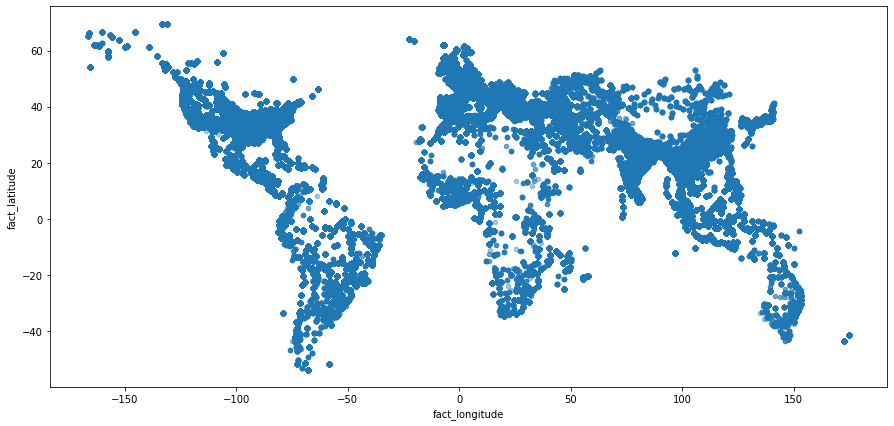

In [17]:
test_df = pd.read_csv("data/test_feat.csv", low_memory=True)
test_df.plot(kind="scatter", x="fact_longitude", y="fact_latitude", alpha=0.4,
              cmap=plt.get_cmap("jet"), figsize=(15,7))
plt.show()
indices = test_df.pop("index")

# add info about month and hour
test_df = get_categorical_month_and_hour(test_df)
# drop features
final_test_df = test_df.drop(columns=features_to_remove)
final_test_df = final_test_df.drop(columns=["fact_time", "gfs_available", "cmc_available", "wrf_available"])

In [ ]:
# APPLY PCA TO TEST
# X_test = final_test_df.to_numpy()
X_test = pca.transform(final_test_df)

In [18]:
# Get X_test and normalize
X_test = final_test_df.to_numpy()
X_test = sc.transform(X_test)

c:\users\andrea\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
y_pred = model.predict(X_test)
y_pred = scy.inverse_transform(y_pred)

In [25]:
print(f"Min value: {y_pred.min()}")
print(f"Max value: {y_pred.max()}")

Min value: -40.32438659667969
Max value: 45.809383392333984


In [26]:
submission_df = pd.DataFrame(data={'index': indices.values,
                                   'fact_temperature': y_pred.squeeze()})

# Save the predictions into a csv file
# Notice that this file should be saved under the directory `/kaggle/working` 
# so that you can download it later
submission_df.to_csv("submission.csv", index=False)

# Old stuff

In [ ]:
plt.figure(figsize = (13,8))
nan_corr_df = train_df[nan_cols].corr() 
sns.heatmap(nan_corr_df)
plt.tight_layout()
plt.show()

In [ ]:
nan_corr_mat = nan_corr_df.corr().abs()
# select upper triangle of corr matrix
upper = nan_corr_mat.where(np.triu(np.ones(nan_corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))
to_drop

In [ ]:
upper['cmc_0_0_7_925']

In [ ]:
train_df.columns.values

In [ ]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper
# to drop: cmc_0_2_2_1000, cmc_0_2_2_925, cmc_0_2_3_1000, cmc_0_2_3_925

In [ ]:
cmc02 = ['cmc_0_2_2_10',
           'cmc_0_2_2_1000', 'cmc_0_2_2_500', 'cmc_0_2_2_700',
           'cmc_0_2_2_850', 'cmc_0_2_2_925', 'cmc_0_2_3_10', 'cmc_0_2_3_1000',
           'cmc_0_2_3_500', 'cmc_0_2_3_700', 'cmc_0_2_3_850', 'cmc_0_2_3_925']
corr_cmc02 = train_df[cmc02].corr() > 0.85
# select upper triangle of corr matrix
upper = corr_cmc02.where(np.triu(np.ones(corr_cmc02.shape), k=1).astype(np.bool))
upper

In [ ]:
final_train_df = train_df.copy()
to_keep = ['fact_latitude','fact_longitude','topography_bathymery','sun_elevation', 'climate_temperature', 'climate_pressure',
         'cmc_0_0_6_2', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_1_0_0']

In [ ]:
train_df_samples['fact_temperature'].to_numpy()

In [ ]:
train_df_samples = train_df.sample(int(0.4 * len(train_df)))

In [ ]:
y = train_df_samples['fact_temperature'].to_numpy()
X = train_df_samples.fillna(0).iloc[:,:-1].to_numpy()

In [ ]:
# grid search cv

param_grid = {
            "alpha": [1]
            }
gs = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring="neg_mean_squared_error", n_jobs=-1,cv=5, verbose=True)
gs.fit(X,y)